# Importando Bibliotecas e Funções

In [60]:
#permitir auto-complete dos codigos com tab
%config Completer.use_jedi = False

#manipular dados
import pandas as pd
from pandas import json_normalize
import numpy as np
from ast import literal_eval

#requisicoes de API
import requests
import json

#manipular datas
import time
import datetime

#manipular strings
from unidecode import unidecode

#plotar e visualizar
import seaborn as sns
import matplotlib.pyplot as plt

#remover warnings
import warnings
warnings.simplefilter("ignore")

#aumentar display de linhas e colunas
pd.set_option('display.max_columns',250)

pd.set_option('display.min_rows',30)
pd.set_option('display.max_rows',30)

In [170]:
#valores a serem informados nas requisições

payload={}

headers = {
  'x-rapidapi-key': 'c58a251d827eeee96ac5cb890e882cc9',
  'x-rapidapi-host': 'v3.football.api-sports.io'
}

stream_req = 'https://v3.football.api-sports.io/fixtures?date='
fix_req = "https://v3.football.api-sports.io/fixtures?ids="
odds_req = 'https://v3.football.api-sports.io/odds?fixture='
pred_req = 'https://v3.football.api-sports.io/predictions?fixture='
hxh_req = 'https://v3.football.api-sports.io/fixtures/headtohead?h2h='

In [62]:
def flatten_nested_json_df(df):

    '''
    abre um Json até o último nível, trazendo todas as colunas para o nível mais alto, 
    no processo, repete alguns valores para as linhas
    args:
        df (DataFrame): dataframe contendo colunas em Json
    returns:
        df (DataFrame): dataframe contendo todas as informacoes do Json

    notes:
        em certos Json com muitas informações, pode ocorrer um MemoryError. Recomenda combinar a função com
        .explode() e json_normalize(record_path = [], meta = []) para melhores resultados
    '''

    df = df.reset_index()
    s = (df.applymap(type) == list).all()
    list_columns = s[s].index.tolist()
    s = (df.applymap(type) == dict).all()
    dict_columns = s[s].index.tolist()
    while len(list_columns) > 0 or len(dict_columns) > 0:
        new_columns = []
        for col in dict_columns:
            horiz_exploded = pd.json_normalize(df[col]).add_prefix(f'{col}.')
            horiz_exploded.index = df.index
            df = pd.concat([df, horiz_exploded], axis=1).drop(columns=[col])
            new_columns.extend(horiz_exploded.columns)
        for col in list_columns:
            df = df.drop(columns=[col]).join(df[col].explode().to_frame())
            new_columns.append(col)
        s = (df[new_columns].applymap(type) == list).all()
        list_columns = s[s].index.tolist()
        s = (df[new_columns].applymap(type) == dict).all()
        dict_columns = s[s].index.tolist()
    return df

In [135]:
def transform_fixture(df):
    
    '''
    utilizado no output das requisições de partidas/fixtures
    realiza a abertura e manipulação para o formato desejado para as colunas
    statistics, players, lineups e events
    
    args:
        df (DataFrame): dataframe de partidas contendo as colunas 'statistics', 'players', 'lineups' e 'events'
    
    returns:
        {nome_desejado} (List): list com 4 dataframes contendo em
        [0] = events
        [1] = lineups
        [2] = players
        [3] = statistics
    '''
    
    #abre o json da coluna 'statistics'
    statistics = []
    
    for i,j in zip(range(df.shape[0]),stats['fixture.id']):
        try:
            st = json_normalize(df['statistics'].iloc[i],
                                record_path=['statistics'],
                                meta=[['team', 'id'], ['team', 'name'],
                                      ['team', 'logo']])

            st = pd.pivot(st,
                          index=['team.name', 'team.id', 'team.logo'],
                          columns=['type'],
                          values=['value']).reset_index()

            #st.index = st.reset_index()['index']

            st['fixture.id'] = j

            statistics.append(st)

        except Exception:
            pass

    try:
        sts = pd.concat(statistics)
    except Exception:
        pass

    #renomeia as colunas removendo o multi_index 'value'
    cols = sts.columns
    cols = [col[1] if col[0] == 'value' else col[0] for col in cols]
    sts.columns = cols

    #transformar as variáveis BP e P% em numéricas
    sts['Ball Possession'] = sts['Ball Possession'].str.strip('%').astype(float)
    sts['Passes %'] = sts['Passes %'].str.strip('%').astype(float)

    #transforma as demais colunas em numéricas
    for i in sts.iloc[:,3:].columns:
        sts[i].astype(float)

    sts.iloc[:,3:] = sts.iloc[:,3:].astype(float)
    
    #abre o json da coluna 'players'
    players = []

    for i, j in zip(range(stats.shape[0]), stats['fixture.id']):
        try:
            pl = flatten_nested_json_df(
                json_normalize(stats['players'].iloc[i], ['players'],
                               [['team', 'name'], ['team', 'id'], ['team', 'logo']]))

            pl['fixture.id'] = j

            players.append(pl)

        except Exception:
            pass

    try:
        pls = pd.concat(players)
    except Exception:
        pass

    #ajustes nos dados de players
    #passes accuracy - transforma em variável numérica
    pls['statistics.passes.accuracy'] = [
        str(value).replace("%", "") if value != 'None' else value
        for value in pls['statistics.passes.accuracy']
    ]
    pls['statistics.passes.accuracy'] = pls['statistics.passes.accuracy'].replace(
        'None', np.nan).astype(float)

    #passes accuracy - calcula a média por time
    pls_pa = pls[['statistics.passes.accuracy','fixture.id','team.name','team.id']]\
    .groupby(['fixture.id','team.name','team.id'], as_index = False)\
    .mean().iloc[:,3]

    #games rating - transforma em variável numérica - agrupa Goleiro dentro de Defesa
    pls['statistics.games.rating'] = pls['statistics.games.rating'].replace(
        '-', np.nan).replace('–', np.nan)
    pls['statistics.games.rating'] = pls['statistics.games.rating'].astype(float)
    pls['statistics.games.position'] = pls[
        'statistics.games.position'].str.replace('G', 'D')

    #games rating - calcula a média por time e por grupo (F, D, M)
    plrt = pls.groupby(['fixture.id', 'team.id', 'statistics.games.position'],
                       as_index=False)[[
                           'statistics.games.rating'
                       ]].mean().sort_values(by=['fixture.id', 'team.id'])
    plrt = plrt.pivot(values='statistics.games.rating',
                      index=['fixture.id', 'team.id'],
                      columns='statistics.games.position')
    plrt.columns = [f'statistics.games.rating.{col}' for col in plrt.columns]
    try:
        plrt = plrt.drop(columns='statistics.games.rating.SUB').reset_index()
    except Exception:
        pass

    #games rating - calcula a média geral por time
    pls_gr = pls[['statistics.games.rating','fixture.id','team.name','team.id']]\
    .groupby(['fixture.id','team.name','team.id'], as_index = False)\
    .mean().iloc[:,3]

    #filtra as variáveis de interesse
    pls = pls.filter([
        'team.id', 'team.name', 'team.logo', 'fixture.id', 'league_round',
        'statistics.offsides', 'statistics.shots.total', 'statistics.shots.on',
        'statistics.goals.total', 'statistics.goals.conceded',
        'statistics.goals.assists', 'statistics.goals.saves',
        'statistics.passes.total', 'statistics.passes.key',
        'statistics.passes.accuracy', 'statistics.tackles.total',
        'statistics.tackles.blocks', 'statistics.tackles.interceptions',
        'statistics.duels.total', 'statistics.duels.won',
        'statistics.dribbles.attempts', 'statistics.dribbles.success',
        'statistics.dribbles.past', 'statistics.fouls.drawn',
        'statistics.fouls.committed', 'statistics.cards.yellow',
        'statistics.cards.red', 'statistics.penalty.won',
        'statistics.penalty.commited', 'statistics.penalty.scored',
        'statistics.penalty.missed', 'statistics.penalty.saved', 'statistics.games.rating'
    ])


    #transforma as variáveis filtradas em float
    for i in pls.iloc[:, 3:].columns:
        pls[i] = pls[i].astype(float)

    #realiza a soma por time
    pls = pls.groupby(['fixture.id','team.name','team.id'],\
                 as_index = False)\
    .sum()

    #substitui a variável passes accuracy e games rating
    pls['statistics.passes.accuracy'] = pls_pa
    pls['statistics.games.rating'] = pls_gr

    #faz um merge dos ratings por time/grupo
    pls = pls.merge(plrt, on=['fixture.id', 'team.id'])

    #abre o json da coluna 'lineups'
    lineups = []

    for i, j in zip(range(stats.shape[0]), stats['fixture.id']):
        try:
            lp = json_normalize(stats['lineups'].iloc[i])
            lp['fixture.id'] = j
            lineups.append(lp)

        except Exception:
            pass


    lps = pd.concat(lineups)
    lps = lps.iloc[:,:]

    #ver o time inteiro 
    #titulares #flatten_nested_json_df(json_normalize(stats['lineups'].iloc[3]).drop(columns = 'substitutes'))
    #substitutos #flatten_nested_json_df(json_normalize(stats['lineups'].iloc[3]).drop(columns = 'startXI'))

    #abre o json da coluna 'events'
    events = []

    for i, j in zip(range(stats.shape[0]), stats['fixture.id']):
        try:
            ev = (json_normalize(stats['events'].iloc[i]))

            ev = ev.groupby(['team.id', 'detail'],
                                         as_index=False).count()

            ev = ev.pivot_table(index=['team.id'], columns='detail',
                                values='type').reset_index()

            ev['fixture.id'] = j

            events.append(ev)

        except Exception:
            pass

    evts = pd.concat(events)
    
    return evts, lps, pls, sts

In [63]:
def req_padrao(req,iterador):
    
    '''
    
    
    args:

    
    returns:

    ''' 
    ls_v = []
    
    fixrange = req + str(iterador)
    fix_d = requests.request("GET",
                                  fixrange,
                                  headers=headers,
                                  data=payload)
    fix_d = fix_d.json()
    fix_d = json_normalize(fix_d['response'])
    ls_v.append(fix_d)
    
    return pd.concat(ls_v)
def req_alt(req, iterador):
    
    ls_v = []
    
    fixrange = req + str(iterador)
    fix_d = requests.request("GET",
                                  fixrange,
                                  headers=headers,
                                  data=payload)
    fix_d = fix_d.json()
    fix_d = json_normalize(fix_d['response'])
    fix_d['fixture.id'] = iterador
    ls_v.append(fix_d)
    
    return pd.concat(ls_v)
def req_hxh(req, iterador1, iterador2):
    
    ls_v = []
    
    fixrange = req + str(iterador1)
    fix_d = requests.request("GET",
                                  fixrange,
                                  headers=headers,
                                  data=payload)
    fix_d = fix_d.json()
    fix_d = json_normalize(fix_d['response'])
    fix_d['fixture.id.ns'] = iterador2
    ls_v.append(fix_d)
    
    return pd.concat(ls_v)

In [195]:
def viz_confrontos(df_predx):
    
    '''
    utilizado para visualizacao das previsões geradas pela API para uma partida em questão
    
    args:
        df (DataFrame): dataframe de previsoes
    
    returns:
        graph: gráficos de diferença percentual entre variáveis do time 
        'form, att, def, poisson, h2h' e previsão sugerida
        gráfico de barras agrupadas (stacked) e gráfico de radar/teia-de-aranha
    '''
    import matplotlib.pyplot as plt
    from math import pi
    
    df_predx[['fixture.id','teams.home.id','teams.home.name','teams.away.name','teams.away.id','predictions.advice']]

    comp = pd.concat([df_predx[['teams.home.name','teams.away.name']],df_predx[['comparison.form.home',
     'comparison.form.away',
     'comparison.att.home',
     'comparison.att.away',
     'comparison.def.home',
     'comparison.def.away',
     'comparison.poisson_distribution.home',
     'comparison.poisson_distribution.away',
     'comparison.h2h.home',
     'comparison.h2h.away',
     'comparison.goals.home',
     'comparison.goals.away',
     'comparison.total.home',
     'comparison.total.away']]], axis = 1)

    X = comp.filter(regex='.home')
    X.columns = X.columns.str.replace('.home','')
    Y = comp.filter(regex='.away')
    Y.columns = Y.columns.str.replace('.away','')

    compxy = pd.concat([X,Y])
    for i in compxy.iloc[:,1:].columns:
        compxy[i] = compxy[i].str.replace('%','').astype(float)

    compxy.columns = compxy.columns.str.replace('comparison.','')

#     df = compxy.set_index('teams.name')

#     fig, ax = plt.subplots(figsize = (10,5))

#     df.T.plot(kind='barh', stacked=True, ax = ax, color = ['chocolate','olivedrab'])
#     plt.axvline(x=50, color='black')


#     #legend
#     ax.legend(bbox_to_anchor=(1.01, 1.01))

#     # labels for x & y axis
#     plt.xlabel('Desempenho: 0 - 100%')
#     plt.ylabel('Variáveis')

#     # title of plot
#     plt.title('Comparação Times')

#     # observation
#     plt.figtext(.83, 0.5, str(list(df_predx['predictions.advice'])).replace('[','').replace(']','').replace("'",""))

#     a = plt.show()
    


    df = compxy

    fig,ax = plt.subplots(figsize = (6,6))
    # number of variable
    categories=list(df)[1:]
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(111, polar=True)

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels
    plt.xticks(angles[:-1], categories)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([10,20,30,40,50,60,70,80,90,100], ["10","20","30","40","50","60","70","80","90","100"], color="grey", size=10)
    plt.ylim(0,100)

    # Ind1

    values=df.iloc[0,1:].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1.2, linestyle='solid', label=compxy.iloc[0,0])
    ax.fill(angles, values, 'b', alpha=0.1)

    # Ind2
    values=df.iloc[1,1:].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1.2, linestyle='solid', label=compxy.iloc[1,0])
    ax.fill(angles, values, 'r', alpha=0.1)

    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

    # observation
    plt.figtext(.97, 0.5, str(list(df_predx['predictions.advice'])).replace('[','').replace(']','').replace("'",""))


    # Show the graph
    plt.show()
    
    b = plt.show
    
    return b

# 1. Request de Partidas Recentes, a Ocorrer ou Futuras
#### - Histórico de Confrontos, Previsões da API, Análises de Momento para Bets

## 1.1 Buscar as partidas que ainda ocorrerão

In [119]:
#cria um range de datas para +- X dias

from datetime import datetime
date = datetime.today().strftime('%Y-%m-%d')

#seleciona a range de datas
import datetime
x_dias_inicio = 0
x_dias_fim = 5

#date = hoje, datet0 = hoje - X dias, datet1 = hoje + X dias
datet0 = (datetime.date.today()) + datetime.timedelta(days=-x_dias_inicio)
datet1 = (datetime.date.today()) + datetime.timedelta(days=+x_dias_fim)

In [120]:
#escolher data inicio e fim - opcoes (date = hoje, datet0 = hoje - X dias, datet1 = hoje + X dias)

#data inicio
print(datet0)

#data fim
print(datet1)

#puxa as datas de inicio até a data fim
date_list = (pd.date_range(start=datet0, end=datet1,
                           freq='D')).strftime('%Y-%m-%d').tolist()
date_list

2023-04-05
2023-04-10


['2023-04-05',
 '2023-04-06',
 '2023-04-07',
 '2023-04-08',
 '2023-04-09',
 '2023-04-10']

In [75]:
df_stream = pd.concat([req_padrao(stream_req,i) for i in date_list])

In [76]:
#verifica a quantidade de partidas por 'status'
print(df_stream.groupby(['fixture.status.long']).size())

#confere a quantidade de partidas que ainda não ocorreram
print(len(df_stream[df_stream['fixture.status.short']=='NS']))

fixture.status.long
Extra Time                1
First Half               16
Halftime                  8
In Progress               1
Match Cancelled          42
Match Finished          121
Match Postponed          35
Match Suspended           1
Not Started            3626
Penalty in progress       1
Second Half              15
Technical loss            1
Time to be defined       28
dtype: int64
3626


## 1.2 Selecionar Partidas - Por lista de partidas ou apenas uma

### 1.2.1 Selecionar uma lista de partidas

In [79]:
#filtra as partidas de acordo com critérios
     #todas as partidas
df_stream
     #partidas apenas do pais selecionado ou de todos os paises
print('Selecione um país (nome em inglês) - Se deixar em branco, selecionará todos')
ipt = input()
if len(ipt)>0:
    partidas_stream_league = (df_stream[df_stream['league.country']==str(ipt)])
else:
    partidas_stream_league = (df_stream)
     #partidas apenas do pais selecionado e que ainda nao ocorreram
partidas_stream_league_ns = partidas_stream_league[partidas_stream_league['fixture.status.long']=="Not Started"]

#cria uma lista com as fixture.ids para iterar
     #todas as partidas
ps = list(df_stream['fixture.id'])
     #partidas apenas do pais selecionado
pslg = list(partidas_stream_league['fixture.id'])
     #partidas apenas do pais selecionado e que ainda nao ocorreram
pslgns = list(partidas_stream_league_ns['fixture.id'])

Selecione um país (nome em inglês) - Se deixar em branco, selecionará todos
England


In [80]:
partidas_stream_league_ns[['teams.home.name','teams.away.name','league.name','fixture.date']]

,teams.home.name,teams.away.name,league.name,fixture.date
261,Swindon Supermarine,Plymouth Parkway,Non League Premier - Southern South,2023-04-05T18:45:00+00:00
263,Tavistock,AFC Totton,Non League Div One - Southern South,2023-04-05T18:45:00+00:00
264,Biggleswade,Didcot Town,Non League Div One - Southern Central,2023-04-05T18:45:00+00:00
268,West Ham,Newcastle,Premier League,2023-04-05T19:00:00+00:00
269,Manchester United,Brentford,Premier League,2023-04-05T19:00:00+00:00
101,Coventry City U21,Crewe Alexandra U21,Professional Development League,2023-04-06T12:00:00+00:00
414,Bracknell Town,Metropolitan Police,Non League Premier - Southern South,2023-04-06T18:45:00+00:00
78,Reading U21,Queens Park Rangers U21,Professional Development League,2023-04-07T10:00:00+00:00
112,Blackburn Rovers U21,Crystal Palace U21,Premier League 2 Division One,2023-04-07T11:00:00+00:00
132,Millwall,Luton,Championship,2023-04-07T11:30:00+00:00


In [81]:
#confere o tamanho
len(pslgns)

415

### 1.2.2 Selecionar uma partida em específico

In [163]:
#buscar partidas na liga desejada
print('Insira um país para visualizar as ligas que estão tendo partidas nas datas selecionadas')
country_name = input()

if len(ipt)>0:
    partidas_stream_league = (df_stream[df_stream['league.country']==str(country_name)])
else:
    partidas_stream_league = (df_stream)

#mostra todas as ligas para a selecao de partidas
print(partidas_stream_league['league.name'].unique())

Insira um país para visualizar as ligas que estão tendo partidas nas datas selecionadas


KeyboardInterrupt: Interrupted by user

In [83]:
#buscar partidas na liga desejada
print('Insira a liga desejada')
league_name = input()

partidas_stream_league.query("`league.name` == '" + league_name + "'")[['fixture.id','fixture.date','teams.home.name','teams.away.name','league.country']]

Insira a liga desejada
Premier League


,fixture.id,fixture.date,teams.home.name,teams.away.name,league.country
268,868015,2023-04-05T19:00:00+00:00,West Ham,Newcastle,England
269,868192,2023-04-05T19:00:00+00:00,Manchester United,Brentford,England
232,868242,2023-04-08T11:30:00+00:00,Manchester United,Everton,England
588,868236,2023-04-08T14:00:00+00:00,Aston Villa,Nottingham Forest,England
589,868237,2023-04-08T14:00:00+00:00,Brentford,Newcastle,England
590,868238,2023-04-08T14:00:00+00:00,Fulham,West Ham,England
591,868240,2023-04-08T14:00:00+00:00,Leicester,Bournemouth,England
592,868244,2023-04-08T14:00:00+00:00,Tottenham,Brighton,England
593,868245,2023-04-08T14:00:00+00:00,Wolves,Chelsea,England
1144,868243,2023-04-08T16:30:00+00:00,Southampton,Manchester City,England


In [165]:
#opção - selecionar o ID específico da partida para a qual se deseja ver as estatísticas

print('Insira o ID da Partida desejada')
pslgns = input()

partidas_stream_league_ns = df_stream.query("`fixture.id`=="+str(pslgns))

partidas_stream_league_ns

Insira o ID da Partida desejada
868241


,fixture.id,fixture.referee,fixture.timezone,fixture.date,fixture.timestamp,fixture.periods.first,fixture.periods.second,fixture.venue.id,fixture.venue.name,fixture.venue.city,fixture.status.long,fixture.status.short,fixture.status.elapsed,league.id,league.name,league.country,league.logo,league.flag,league.season,league.round,teams.home.id,teams.home.name,teams.home.logo,teams.home.winner,teams.away.id,teams.away.name,teams.away.logo,teams.away.winner,goals.home,goals.away,score.halftime.home,score.halftime.away,score.fulltime.home,score.fulltime.away,score.extratime.home,score.extratime.away,score.penalty.home,score.penalty.away
498,868241,P. Tierney,UTC,2023-04-09T15:30:00+00:00,1681054200,None,None,550.0,Anfield,Liverpool,Not Started,NS,None,39,Premier League,England,https://media-2.api-sports.io/football/leagues...,https://media-1.api-sports.io/flags/gb.svg,2022,Regular Season - 30,40,Liverpool,https://media-1.api-sports.io/football/teams/4...,None,42,Arsenal,https://media-1.api-sports.io/football/teams/4...,None,None,None,None,None,None,None,None,None,None,None


## 1.3 Buscar todas as estatísticas de confrontos anteriores

In [89]:
#busca o id dos times que se enfrentarão e coloca no formato 'id1-id2' para fazer a requisição HeadxHead
hxh_l = (partidas_stream_league_ns['teams.home.id']).astype(str) + '-' + (partidas_stream_league_ns['teams.away.id']).astype(str)
hxh_l = list(hxh_l)

hxh_f = list(partidas_stream_league_ns['fixture.id'])

#print(hxh_l)

In [90]:
#confere o tamanho
len(hxh_f)

1

In [91]:
#faz a requisição dos confrontos anteriores entre os times que irão jogar
htoh = pd.concat([req_hxh(hxh_req,i,j) for i,j in zip(hxh_l, hxh_f)]).reset_index(drop =  True)

In [92]:
#cria lista de ids dos conflitos que servirá para iteração
htoh_df_l = list(htoh['fixture.id'])

In [93]:
#confere o tamanho
len(htoh_df_l)

32

In [94]:
#cria a variável 'resultado', indicando se foi vitória do time da casa, empate ou vitória do visitante
htoh['resultado'] = np.where(htoh['teams.away.winner']==False, 'Hw',np.where(htoh['teams.away.winner']==True,'Aw','D'))

In [95]:
#faz a requisição dos dados das partidas - estatisticas gerais, jogadores, lineups e eventos
stats = pd.concat([req_padrao(fix_req,i) for i in htoh_df_l]).sort_values(by = 'fixture.date')

In [96]:
#confere o tamanho
len(stats)

32

In [121]:
stats.tail(6)

,events,lineups,statistics,players,fixture.id,fixture.referee,fixture.timezone,fixture.date,fixture.timestamp,fixture.periods.first,fixture.periods.second,fixture.venue.id,fixture.venue.name,fixture.venue.city,fixture.status.long,fixture.status.short,fixture.status.elapsed,league.id,league.name,league.country,league.logo,league.flag,league.season,league.round,teams.home.id,teams.home.name,teams.home.logo,teams.home.winner,teams.away.id,teams.away.name,teams.away.logo,teams.away.winner,goals.home,goals.away,score.halftime.home,score.halftime.away,score.fulltime.home,score.fulltime.away,score.extratime.home,score.extratime.away,score.penalty.home,score.penalty.away
0,"[{'time': {'elapsed': 39, 'extra': None}, 'tea...","[{'team': {'id': 40, 'name': 'Liverpool', 'log...","[{'team': {'id': 40, 'name': 'Liverpool', 'log...","[{'team': {'id': 40, 'name': 'Liverpool', 'log...",710669,M. Oliver,UTC,2021-11-20T17:30:00+00:00,1637429400,1637429400,1637433000,550,Anfield,Liverpool,Match Finished,FT,90,39,Premier League,England,https://media-1.api-sports.io/football/leagues...,https://media-3.api-sports.io/flags/gb.svg,2021,Regular Season - 12,40,Liverpool,https://media-3.api-sports.io/football/teams/4...,True,42,Arsenal,https://media-1.api-sports.io/football/teams/4...,False,4,0,1,0,4,0,None,None,None,None
0,"[{'time': {'elapsed': 11, 'extra': None}, 'tea...","[{'team': {'id': 40, 'name': 'Liverpool', 'log...","[{'team': {'id': 40, 'name': 'Liverpool', 'log...","[{'team': {'id': 40, 'name': 'Liverpool', 'log...",820051,M. Oliver,UTC,2022-01-13T19:45:00+00:00,1642103100,1642103100,1642106700,550,Anfield,Liverpool,Match Finished,FT,90,48,League Cup,England,https://media-1.api-sports.io/football/leagues...,https://media-1.api-sports.io/flags/gb.svg,2021,Semi-finals,40,Liverpool,https://media-2.api-sports.io/football/teams/4...,None,42,Arsenal,https://media-3.api-sports.io/football/teams/4...,None,0,0,0,0,0,0,None,None,None,None
0,"[{'time': {'elapsed': 19, 'extra': None}, 'tea...","[{'team': {'id': 42, 'name': 'Arsenal', 'logo'...","[{'team': {'id': 42, 'name': 'Arsenal', 'logo'...","[{'team': {'id': 42, 'name': 'Arsenal', 'logo'...",820050,M. Atkinson,UTC,2022-01-20T19:45:00+00:00,1642707900,1642707900,1642711500,494,Emirates Stadium,London,Match Finished,FT,90,48,League Cup,England,https://media-1.api-sports.io/football/leagues...,https://media-1.api-sports.io/flags/gb.svg,2021,Semi-finals,42,Arsenal,https://media-1.api-sports.io/football/teams/4...,False,40,Liverpool,https://media-1.api-sports.io/football/teams/4...,True,0,2,0,1,0,2,None,None,None,None
0,"[{'time': {'elapsed': 54, 'extra': None}, 'tea...","[{'team': {'id': 42, 'name': 'Arsenal', 'logo'...","[{'team': {'id': 42, 'name': 'Arsenal', 'logo'...","[{'team': {'id': 42, 'name': 'Arsenal', 'logo'...",710816,A. Marriner,UTC,2022-03-16T20:15:00+00:00,1647461700,1647461700,1647465300,494,Emirates Stadium,London,Match Finished,FT,90,39,Premier League,England,https://media-2.api-sports.io/football/leagues...,https://media-2.api-sports.io/flags/gb.svg,2021,Regular Season - 27,42,Arsenal,https://media-1.api-sports.io/football/teams/4...,False,40,Liverpool,https://media-2.api-sports.io/football/teams/4...,True,0,2,0,0,0,2,None,None,None,None
0,"[{'time': {'elapsed': 1, 'extra': None}, 'team...","[{'team': {'id': 42, 'name': 'Arsenal', 'logo'...","[{'team': {'id': 42, 'name': 'Arsenal', 'logo'...","[{'team': {'id': 42, 'name': 'Arsenal', 'logo'...",868037,"Michael Oliver, England",UTC,2022-10-09T15:30:00+00:00,1665329400,1665329400,1665333000,494,Emirates Stadium,London,Match Finished,FT,90,39,Premier League,England,https://media-1.api-sports.io/football/leagues...,https://media-3.api-sports.io/flags/gb.svg,2022,Regular Season - 10,42,Arsenal,https://media-3.api-sports.io/football/teams/4...,True,40,Liverpool,https://media-3.api-sports.io/football/teams/4...,False,3,2,2,1,3,2,None,None,None,None
0,[],[],[],[],868241,P. Tierney,UTC,2023-04-09T15:30:00+00:00,1681054200,None,None,550,Anfield,

In [136]:
#aplica a função para extrair as informações dos campos statisticas, players e lineups
statis_f = transform_fixture(stats)

In [137]:
#dobra o tamanho dataframe de HeadxHead dos times que se enfrentarão, dividindo os jogos em 1 linha por time
htoh1 = htoh.copy()
htoh1['team.id'] = htoh1['teams.home.id']

htoh2 = htoh.copy()
htoh2['team.id'] = htoh2['teams.away.id']

htoh_c = pd.concat([htoh1,htoh2]).sort_values(by = 'fixture.date')

htoh_c.tail()

,fixture.id,fixture.referee,fixture.timezone,fixture.date,fixture.timestamp,fixture.periods.first,fixture.periods.second,fixture.venue.id,fixture.venue.name,fixture.venue.city,fixture.status.long,fixture.status.short,fixture.status.elapsed,league.id,league.name,league.country,league.logo,league.flag,league.season,league.round,teams.home.id,teams.home.name,teams.home.logo,teams.home.winner,teams.away.id,teams.away.name,teams.away.logo,teams.away.winner,goals.home,goals.away,score.halftime.home,score.halftime.away,score.fulltime.home,score.fulltime.away,score.extratime.home,score.extratime.away,score.penalty.home,score.penalty.away,fixture.id.ns,resultado,team.id
13,710816,A. Marriner,UTC,2022-03-16T20:15:00+00:00,1647461700,1.647462e+09,1.647465e+09,494.0,Emirates Stadium,London,Match Finished,FT,90.0,39,Premier League,England,https://media-3.api-sports.io/football/leagues...,https://media-3.api-sports.io/flags/gb.svg,2021,Regular Season - 27,42,Arsenal,https://media-2.api-sports.io/football/teams/4...,False,40,Liverpool,https://media-2.api-sports.io/football/teams/4...,True,0.0,2.0,0.0,0.0,0.0,2.0,NaN,NaN,NaN,NaN,868241,Aw,42
15,868037,"Michael Oliver, England",UTC,2022-10-09T15:30:00+00:00,1665329400,1.665329e+09,1.665333e+09,494.0,Emirates Stadium,London,Match Finished,FT,90.0,39,Premier League,England,https://media-3.api-sports.io/football/leagues...,https://media-2.api-sports.io/flags/gb.svg,2022,Regular Season - 10,42,Arsenal,https://media-2.api-sports.io/football/teams/4...,True,40,Liverpool,https://media-1.api-sports.io/football/teams/4...,False,3.0,2.0,2.0,1.0,3.0,2.0,NaN,NaN,NaN,NaN,868241,Hw,42
15,868037,"Michael Oliver, England",UTC,2022-10-09T15:30:00+00:00,1665329400,1.665329e+09,1.665333e+09,494.0,Emirates Stadium,London,Match Finished,FT,90.0,39,Premier League,England,https://media-3.api-sports.io/football/leagues...,https://media-2.api-sports.io/flags/gb.svg,2022,Regular Season - 10,42,Arsenal,https://media-2.api-sports.io/football/teams/4...,True,40,Liverpool,https://media-1.api-sports.io/football/teams/4...,False,3.0,2.0,2.0,1.0,3.0,2.0,NaN,NaN,NaN,NaN,868241,Hw,40
31,868241,P. Tierney,UTC,2023-04-09T15:30:00+00:00,1681054200,NaN,NaN,550.0,Anfield,Liverpool,Not Started,NS,NaN,39,Premier League,England,https://media-3.api-sports.io/football/leagues...,https://media-2.api-sports.io/flags/gb.svg,2022,Regular Season - 30,40,Liverpool,https://media-2.api-sports.io/football/teams/4...,None,42,Arsenal,https://media-3.api-sports.io/football/teams/4...,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,868241,D,40
31,868241,P. Tierney,UTC,2023-04-09T15:30:00+00:00,1681054200,NaN,NaN,550.0,Anfield,Liverpool,Not Started,NS,NaN,39,Premier League,England,https://media-3.api-sports.io/football/leagues...,https://media-2.api-sports.io/flags/gb.svg,2022,Regular Season - 30,40,Liverpool,https://media-2.api-sports.io/football/teams/4...,None,42,Arsenal,https://media-3.api-sports.io/football/teams/4...,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,868241,D,42


In [138]:
#faz um merge com os dados de estatísticas gerais, jogadores e formation
 #o intuito e unir as informações de cada time com sua respectiva linha

hh_m = \
htoh_c.merge(statis_f[3], on=['fixture.id', 'team.id'], how='left')\
.merge(statis_f[2], on=['fixture.id', 'team.id', 'team.name'],how='left')\
.merge(statis_f[1],on=['fixture.id', 'team.id', 'team.name','team.logo'],how='left')

hh_m.tail()

,fixture.id,fixture.referee,fixture.timezone,fixture.date,fixture.timestamp,fixture.periods.first,fixture.periods.second,fixture.venue.id,fixture.venue.name,fixture.venue.city,fixture.status.long,fixture.status.short,fixture.status.elapsed,league.id,league.name,league.country,league.logo,league.flag,league.season,league.round,teams.home.id,teams.home.name,teams.home.logo,teams.home.winner,teams.away.id,teams.away.name,teams.away.logo,teams.away.winner,goals.home,goals.away,score.halftime.home,score.halftime.away,score.fulltime.home,score.fulltime.away,score.extratime.home,score.extratime.away,score.penalty.home,score.penalty.away,fixture.id.ns,resultado,team.id,team.name,team.logo,Ball Possession,Blocked Shots,Corner Kicks,Fouls,Goalkeeper Saves,Offsides,Passes %,Passes accurate,Red Cards,Shots insidebox,Shots off Goal,Shots on Goal,Shots outsidebox,Total Shots,Total passes,Yellow Cards,statistics.offsides,statistics.shots.total,statistics.shots.on,statistics.goals.total,statistics.goals.conceded,statistics.goals.assists,statistics.goals.saves,statistics.passes.total,statistics.passes.key,statistics.passes.accuracy,statistics.tackles.total,statistics.tackles.blocks,statistics.tackles.interceptions,statistics.duels.total,statistics.duels.won,statistics.dribbles.attempts,statistics.dribbles.success,statistics.dribbles.past,statistics.fouls.drawn,statistics.fouls.committed,statistics.cards.yellow,statistics.cards.red,statistics.penalty.won,statistics.penalty.commited,statistics.penalty.scored,statistics.penalty.missed,statistics.penalty.saved,statistics.games.rating,statistics.games.rating.D,statistics.games.rating.F,statistics.games.rating.M,startXI,substitutes,formation,team.colors,coach.id,coach.name,coach.photo,team.colors.player.primary,team.colors.player.number,team.colors.player.border,team.colors.goalkeeper.primary,team.colors.goalkeeper.number,team.colors.goalkeeper.border
59,710816,A. Marriner,UTC,2022-03-16T20:15:00+00:00,1647461700,1.647462e+09,1.647465e+09,494.0,Emirates Stadium,London,Match Finished,FT,90.0,39,Premier League,England,https://media-3.api-sports.io/football/leagues...,https://media-3.api-sports.io/flags/gb.svg,2021,Regular Season - 27,42,Arsenal,https://media-2.api-sports.io/football/teams/4...,False,40,Liverpool,https://media-2.api-sports.io/football/teams/4...,True,0.0,2.0,0.0,0.0,0.0,2.0,NaN,NaN,NaN,NaN,868241,Aw,42,Arsenal,https://media-1.api-sports.io/football/teams/4...,48.0,4.0,1.0,9.0,1.0,4.0,81.0,407.0,NaN,3.0,3.0,2.0,6.0,9.0,505.0,NaN,4.0,5.0,2.0,0.0,2.0,0.0,1.0,505.0,7.0,29.071429,16.0,4.0,5.0,87.0,45.0,16.0,14.0,4.0,9.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.685714,6.780000,6.500000,6.700000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60,868037,"Michael Oliver, England",UTC,2022-10-09T15:30:00+00:00,1665329400,1.665329e+09,1.665333e+09,494.0,Emirates Stadium,London,Match Finished,FT,90.0,39,Premier League,England,https://media-3.api-sports.io/football/leagues...,https://media-2.api-sports.io/flags/gb.svg,2022,Regular Season - 10,42,Arsenal,https://media-2.api-sports.io/football/teams/4...,True,40,Liverpool,https://media-1.api-sports.io/football/teams/4...,False,3.0,2.0,2.0,1.0,3.0,2.0,NaN,NaN,NaN,NaN,868241,Hw,42,Arsenal,https://media-1.api-sports.io/football/teams/4...,44.0,3.0,4.0,11.0,2.0,3.0,78.0,302.0,NaN,10.0,1.0,7.0,1.0,11.0,386.0,1.0,3.0,8.0,7.0,3.0,2.0,2.0,2.0,386.0,4.0,21.571429,16.0,3.0,6.0,85.0,46.0,15.0,8.0,4.0,9.0,11.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,7.033333,6.666667,7.633333,7.166667,"[{'player': {'id': 20355, 'name': 'A. Ramsdale...","[{'player': {'id': 1117, 'name': 'K. Tierney',...",4-3-3,NaN,7248,Mikel Arteta,https://media-3.api-sports.io/football/coachs/...,e10000,ffffff,e10000,44c62a,ffffff,44c62a
61,868037,"Michael Oliver, England",UTC,2022-10-09T15:30:00+00:00,1665329400,1.665329e+09,1.665333e+09,494.0,Emirates Stadium,London,Match Finished,FT,90.0,39,Premier League,England,https://media-3.api-sports.io/football/leagues...,https://media-2.api-sports.io/flags/gb.svg,20

In [139]:
#cria uma variável 'wdl' indicando se o time daquela linha ganhou (W), perdeu (L) ou empatou (D) para cada confronto anterior

hh_m['wdl'] = np.where(
    (hh_m['teams.away.winner'] == True) &
    (hh_m['team.id'] == hh_m['teams.away.id']), 'W',
    np.where((hh_m['teams.home.winner'] == True) &
             (hh_m['team.id'] == hh_m['teams.home.id']), 'W',
             np.where((hh_m['teams.home.winner'] == False) &
                      (hh_m['team.id'] == hh_m['teams.home.id']), 'L',
                      np.where((hh_m['teams.away.winner'] == False) &
                               (hh_m['team.id'] == hh_m['teams.away.id']), 'L',
                               'D'))))

In [140]:
#cria uma variável 'gols' indicando quantos gols o time daquela linha fez na partida

hh_m['gols'] = np.where((hh_m['teams.home.id'] == hh_m['team.id']),
                        hh_m['score.fulltime.home'],
                        np.where((hh_m['teams.away.id'] == hh_m['team.id']),
                                 hh_m['score.fulltime.away'], np.nan)).astype('float')

In [141]:
#filtra, do dataframe de confrontos, apenas aqueles que já ocorreram

hh_s = hh_m[(hh_m['fixture.status.short']!='NS') & (hh_m['fixture.status.short']!='TBD')]

In [142]:
#filtra apenas as colunas relevantes para analise dos confrontos

hh_s = hh_s.filter(['fixture.id',
 'fixture.date',
 'fixture.venue.id',
 'fixture.status.long',
 'fixture.status.short',
 'fixture.status.elapsed',
 'league.id',
 'league.name',
 'league.country',
 'league.logo',
 'league.flag',
 'league.season',
 'league.round',
 'teams.home.id',
 'teams.home.name',
 'teams.home.logo',
 'teams.home.winner',
 'teams.away.id',
 'teams.away.name',
 'teams.away.logo',
 'teams.away.winner',
 'gols',
 'score.penalty.home',
 'score.penalty.away',
 'fixture.id.ns',
 'resultado',
 'team.id',
 'team.name',
 'team.logo',
 'Ball Possession',
 'Blocked Shots',
 'Corner Kicks',
 'Fouls',
 'Goalkeeper Saves',
 'Offsides',
 'Passes %',
 'Passes accurate',
 'Red Cards',
 'Shots insidebox',
 'Shots off Goal',
 'Shots on Goal',
 'Shots outsidebox',
 'Total Shots',
 'Total passes',
 'Yellow Cards',
 'statistics.offsides',
 'statistics.shots.total',
 'statistics.shots.on',
 'statistics.goals.total',
 'statistics.goals.conceded',
 'statistics.goals.assists',
 'statistics.goals.saves',
 'statistics.passes.total',
 'statistics.passes.key',
 'statistics.passes.accuracy',
 'statistics.tackles.total',
 'statistics.tackles.blocks',
 'statistics.tackles.interceptions',
 'statistics.duels.total',
 'statistics.duels.won',
 'statistics.dribbles.attempts',
 'statistics.dribbles.success',
 'statistics.dribbles.past',
 'statistics.fouls.drawn',
 'statistics.fouls.committed',
 'statistics.cards.yellow',
 'statistics.cards.red',
 'statistics.penalty.won',
 'statistics.penalty.commited',
 'statistics.penalty.scored',
 'statistics.penalty.missed',
 'statistics.penalty.saved',
 'statistics.games.rating',
 'statistics.games.rating.D',
 'statistics.games.rating.F',
 'statistics.games.rating.M',
 'formation',
 'startXI',
 'substitutes',
 'coach.id',
 'coach.name',
 'coach.photo',
 'wdl'])

In [143]:
#para cada jogo que irá ocorrer, faz uma iteração pelo histórico de conflitos

confront = []

for i in hh_s['fixture.id.ns'].unique():
    try:
        confronto = hh_s[hh_s['fixture.id.ns'] == i].sort_values(
            by='fixture.date').dropna(subset='fixture.status.elapsed').tail(10)
        cf = confronto.groupby(['team.id',
                                'wdl']).size().to_frame().reset_index()

        # agrupa os resultados por equipe e WDL, somando os valores
        grouped = cf.groupby(['team.id', 'wdl']).sum()

        # reorganiza os dados em uma tabela pivô, com colunas para W, D e L
        pivoted = grouped.pivot_table(index='team.id',
                                      columns='wdl',
                                      values=0,
                                      fill_value=0)

        # remove o nome das colunas e reorganiza a ordem das colunas
        if 'W' in pivoted.columns:
            pass  # do nothing
        else:
            pivoted.loc[:, 'W'] = 0

        if 'D' in pivoted.columns:
            pass  # do nothing
        else:
            pivoted.loc[:, 'D'] = 0

        if 'L' in pivoted.columns:
            pass  # do nothing
        else:
            pivoted.loc[:, 'L'] = 0

        # reorganiza as linhas pelo ID da equipe
        wdl = pivoted.reset_index().sort_values('team.id')

        gols = confronto.groupby('team.id')['gols'].sum().to_frame().astype(
            float).reset_index()

        agg = confronto.groupby('team.id').sum().iloc[:, 5:].drop(columns=['fixture.id.ns'])

        pergame = agg.reset_index().copy().set_index('team.id')
        pergame.iloc[:, :] = pergame.iloc[:, :].div(
            cf.groupby('team.id').sum().values, axis=0)
        pergame.columns = [str(col) + '.pergame' for col in pergame.columns]
        pergame = pergame.reset_index()

        pergols = agg.reset_index().set_index('team.id')
        pergols.iloc[:, :] = pergols.iloc[:, :].div(pergols.gols, axis=0)
        pergols.columns = [str(col) + '.pergols' for col in pergols.columns]
        pergols = pergols.reset_index().drop(columns = 'gols.pergols')

        agg.columns = [str(col) + '.agg' for col in agg.columns]
        agg = agg.reset_index()

        form = confronto.groupby('team.id')['formation'].nunique().reset_index(
        ).rename(columns={'formation': 'form_cont'})

        qthxh = cf.groupby('team.id',
                           as_index=False).sum().rename(columns={0: 'qt.hxh'})

        conf = wdl.merge(gols, how='left').merge(agg, how='left').merge(pergame, how='left').merge(
                pergols, how='left', on = 'team.id').merge(form, how='left').merge(qthxh,
                                                                   how='left')
        conf['fixture.id'] = i
        confront.append(conf)
        
    except Exception:
        print(i)

confrontox = pd.concat(confront)

In [144]:
#Remove colunas residuais das ultimas transformacoes, que nao fazem sentido para analise
 #como a o agregado da posse de bola dos times - afinal, nao faz sentido somar porcentagens de 0 a 100
prefixes_to_drop = ["goals.",
"Ball Possession.agg",
"Passes %.agg",
"score.",
"statistics.cards",
"statistics.fouls",
"statistics.games.rating.agg",
"statistics.games.rating.D.agg",
"statistics.games.rating.D.pergols",
"statistics.games.rating.pergols",
"statistics.games.rating.F.agg",
"statistics.games.rating.M.agg",                   
"statistics.games.rating.F.pergols",
"statistics.games.rating.M.pergols",
"statistics.passes.accuracy.agg"
"statistics.goals",
"statistics.offsides",
"statistics.shots.",
"gols.agg",
'Passes %.pergols']

cols_to_drop = [col for col in confrontox.columns if col.startswith(tuple(prefixes_to_drop))]
# Drop the columns from the dataframe
confrontox = confrontox.drop(columns=cols_to_drop)

In [145]:
#dobra o tamanho dataframe, dividindo os jogos em 1 linha por time

partidas_stream_league_ns1 = partidas_stream_league_ns.copy()
partidas_stream_league_ns1['team.id'] = partidas_stream_league_ns1['teams.home.id']

partidas_stream_league_ns2 = partidas_stream_league_ns.copy()
partidas_stream_league_ns2['team.id'] = partidas_stream_league_ns2['teams.away.id']

partidas_stream_league_ns_c = pd.concat([partidas_stream_league_ns1,partidas_stream_league_ns2]).sort_values(by = 'fixture.date')

In [146]:
#faz um merge das estatisticas produzidas acima com a base anterior, das partidas

cft = partidas_stream_league_ns_c[[
    'fixture.id', 'fixture.date', 'fixture.status.long', 'league.id',
    'league.name', 'league.country', 'league.season', 'league.round',
    'teams.home.id', 'teams.home.name', 'teams.home.logo', 'teams.away.id',
    'teams.away.name', 'teams.away.logo', 'team.id'
]].merge(confrontox, how = 'left')

In [147]:
#visualiza os dados
cft.sort_values(by = 'fixture.id', ascending = False).T

#cft.to_excel('teste_confronto.xlsx')

,0,1
fixture.id,868241,868241
fixture.date,2023-04-09T15:30:00+00:00,2023-04-09T15:30:00+00:00
fixture.status.long,Not Started,Not Started
league.id,39,39
league.name,Premier League,Premier League
league.country,England,England
league.season,2022,2022
league.round,Regular Season - 30,Regular Season - 30
teams.home.id,40,40
teams.home.name,Liverpool,Liverpool


In [148]:
#confere o tamanho
len(cft)

2

## 1.4 Odds dos Confrontos Futuros

In [149]:
#faz a requisição das odds oferecidas para a partida
cf_odds = pd.concat([req_padrao(stream_req,i) for i in pslgns])

In [150]:
cf_odds

""


In [151]:
cf_odds_v = []

#da parse no json, transforma as odds em formato long e cria a coluna fixture.id para possibilitar merge

if len(cf_odds)>0:
    for i,j in zip(range(len(cf_odds)),cf_odds['fixture.id']):

        cfo = json_normalize((cf_odds.iloc[i,:])['bookmakers'])
        cfo = flatten_nested_json_df(cfo.explode('bets'))
        cfo = cfo[cfo['bets.name'] == 'Match Winner']
        cfo = cfo[(cfo['name']=='Bet365') | (cfo['name']=='Sportingbet')]
        cfo = cfo.pivot_table(index='name',
                        columns='bets.values.value',
                        values='bets.values.odd').stack().to_frame().reset_index()
        cfo['bet'] = cfo['name'] + cfo['bets.values.value']
        cfo = cfo[['bet',0]].set_index('bet').T.iloc[:,:]
        cfo['fixture.id'] = j
        cf_odds_v.append(cfo)

    cfodds = pd.concat(cf_odds_v)

else:
    cfodds = pd.DataFrame({'fixture.id':[np.nan]})

In [152]:
#merge da base de confrontos com as odds
cft2 = cft.merge(cfodds, how = 'left')

In [153]:
len(cft2)

2

## 1.5 Previsões da API

In [187]:
#faz a requisicao das previsoes fornecidas pela API para os jogos que irao ocorrer, e concatena
if len(pslgns)>8:
    df_pred = pd.concat([req_alt(pred_req,i) for i in pslgns])
else:
    df_pred = pd.concat([req_alt(pred_req,pslgns)])

In [192]:
#divisao das estatisticas fornecidas nas previsoes em time .home e .away

#coloca em index as variaveis comuns a ambos
df_predx = df_pred.set_index([
    'predictions.winner.id', 'predictions.winner.name',
    'predictions.winner.comment', 'predictions.win_or_draw',
    'predictions.under_over'
])

#separa as variaveis referentes ao time .away
df_preda = df_predx.filter([i for i in df_predx.columns if 'away.' in i] + [
    'fixture.id',
    'comparison.form.away',
    'comparison.att.away',
    'comparison.def.away',
    'comparison.poisson_distribution.away',
    'comparison.h2h.away',
    'comparison.goals.away',
    'comparison.total.away',
]).reset_index().rename(columns={'teams.away.id': 'team.id'})

df_preda.columns = df_preda.columns.str.replace('away.', '')

#separa as variaveis referentes ao time .home
df_predh = df_predx.filter([i for i in df_predx.columns if 'home.' in i] + [
    'fixture.id',
    'comparison.form.home',
    'comparison.att.home',
    'comparison.def.home',
    'comparison.poisson_distribution.home',
    'comparison.h2h.home',
    'comparison.goals.home',
    'comparison.total.home',
]).reset_index().rename(columns={'teams.home.id': 'team.id'})

df_predh.columns = df_predh.columns.str.replace('home.', '')

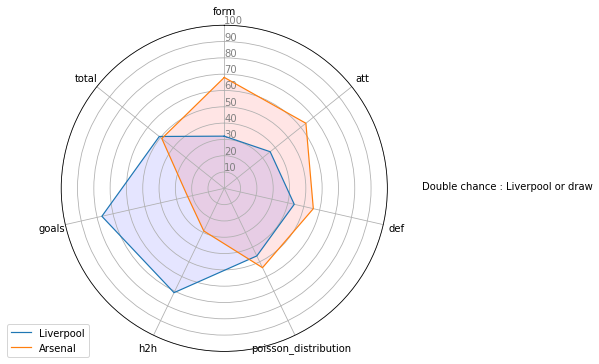

In [196]:
#Visualização dos dados do confronto - no caso de 1 partida selecionada

if len(str(pslgns)) < 8:
    viz_confrontos(df_predx)
    
if len(str(pslgns)) > 8:
    for i in df_predx['fixture.id']:
        viz_confrontos(df_predx[df_predx['fixture.id']==i])

In [197]:
# Substituindo '.home' por '' apenas nas colunas que contêm a palavra 'comparison'
cols_to_replace_h = [col for col in df_predh.columns if 'comparison' in col]
cols_to_replace_a = [col for col in df_preda.columns if 'comparison' in col]
df_predh.rename(columns={col: col.replace('.home', '') for col in cols_to_replace_h}, inplace=True)
df_preda.rename(columns={col: col.replace('.away', '') for col in cols_to_replace_a}, inplace=True)

In [198]:
#concatena as informacoes de home e away novamente, de forma a termos 2 linhas, uma para cada time
df_pred2 = pd.concat([df_predh,df_preda])

In [207]:
#concatena as informacoes com os dados de confrontos
df_pred2[['fixture.id','team.id']] =\
df_pred2[['fixture.id','team.id']].astype(int)

cft3 = cft2.merge(df_pred2, on = ['fixture.id','team.id'], how = 'left')

#remove o simbolo de porcentagem das colunas numéricas
cft3 = cft3.replace({'%':''}, regex = True)

In [208]:
#exporta para excel
cft3.to_excel('estatisticas_confrontos.xlsx')

In [209]:
cft3

,fixture.id,fixture.date,fixture.status.long,league.id,league.name,league.country,league.season,league.round,teams.home.id,teams.home.name,teams.home.logo,teams.away.id,teams.away.name,teams.away.logo,team.id,D,L,W,gols,teams.home.id.agg,teams.away.id.agg,Blocked Shots.agg,Corner Kicks.agg,Fouls.agg,Goalkeeper Saves.agg,Offsides.agg,Passes accurate.agg,Red Cards.agg,Shots insidebox.agg,Shots off Goal.agg,Shots on Goal.agg,Shots outsidebox.agg,Total Shots.agg,Total passes.agg,Yellow Cards.agg,statistics.goals.total.agg,statistics.goals.conceded.agg,statistics.goals.assists.agg,statistics.goals.saves.agg,statistics.passes.total.agg,statistics.passes.key.agg,statistics.passes.accuracy.agg,statistics.tackles.total.agg,statistics.tackles.blocks.agg,statistics.tackles.interceptions.agg,statistics.duels.total.agg,statistics.duels.won.agg,statistics.dribbles.attempts.agg,statistics.dribbles.success.agg,statistics.dribbles.past.agg,statistics.penalty.won.agg,statistics.penalty.commited.agg,statistics.penalty.scored.agg,statistics.penalty.missed.agg,statistics.penalty.saved.agg,teams.home.id.pergame,teams.away.id.pergame,gols.pergame,Ball Possession.pergame,Blocked Shots.pergame,Corner Kicks.pergame,Fouls.pergame,Goalkeeper Saves.pergame,Offsides.pergame,Passes %.pergame,Passes accurate.pergame,Red Cards.pergame,Shots insidebox.pergame,Shots off Goal.pergame,Shots on Goal.pergame,Shots outsidebox.pergame,Total Shots.pergame,Total passes.pergame,Yellow Cards.pergame,statistics.goals.total.pergame,statistics.goals.conceded.pergame,statistics.goals.assists.pergame,statistics.goals.saves.pergame,statistics.passes.total.pergame,statistics.passes.key.pergame,statistics.passes.accuracy.pergame,statistics.tackles.total.pergame,statistics.tackles.blocks.pergame,statistics.tackles.interceptions.pergame,statistics.duels.total.pergame,statistics.duels.won.pergame,statistics.dribbles.attempts.pergame,statistics.dribbles.success.pergame,statistics.dribbles.past.pergame,statistics.penalty.won.pergame,statistics.penalty.commited.pergame,statistics.penalty.scored.pergame,statistics.penalty.missed.pergame,statistics.penalty.saved.pergame,statistics.games.rating.pergame,statistics.games.rating.D.pergame,statistics.games.rating.F.pergame,statistics.games.rating.M.pergame,teams.home.id.pergols,teams.away.id.pergols,Ball Possession.pergols,Blocked Shots.pergols,Corner Kicks.pergols,Fouls.pergols,Goalkeeper Saves.pergols,Offsides.pergols,Passes accurate.pergols,Red Cards.pergols,Shots insidebox.pergols,Shots off Goal.pergols,Shots on Goal.pergols,Shots outsidebox.pergols,Total Shots.pergols,Total passes.pergols,Yellow Cards.pergols,statistics.goals.total.pergols,statistics.goals.conceded.pergols,statistics.goals.assists.pergols,statistics.goals.saves.pergols,statistics.passes.total.pergols,statistics.passes.key.pergols,statistics.passes.accuracy.pergols,statistics.tackles.total.pergols,statistics.tackles.blocks.pergols,statistics.tackles.interceptions.pergols,...,teams.last_5.att,teams.last_5.def,teams.last_5.goals.for.total,teams.last_5.goals.for.average,teams.last_5.goals.against.total,teams.last_5.goals.against.average,teams.league.form,teams.league.fixtures.played.home,teams.league.fixtures.played.away,teams.league.fixtures.played.total,teams.league.fixtures.wins.home,teams.league.fixtures.wins.away,teams.league.fixtures.wins.total,teams.league.fixtures.draws.home,teams.league.fixtures.draws.away,teams.league.fixtures.draws.total,teams.league.fixtures.loses.home,teams.league.fixtures.loses.away,teams.league.fixtures.loses.total,teams.league.goals.for.total.home,teams.league.goals.for.total.away,teams.league.goals.for.total.total,teams.league.goals.for.average.home,teams.league.goals.for.average.away,teams.league.goals.for.average.total,teams.league.goals.for.minute.0-15.total,teams.league.goals.for.minute.0-15.percentage,teams.league.goals.for.minute.16-30.total,teams.league.goals.for.minute.16-30.percentage,teams.league.goals.for.minute.31-45.total,teams

## 1.6 Em Validação - Análise de Jogos Ao Vivo para Bets